In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.samplers import TPESampler, GPSampler
from optuna import visualization

In [2]:
df = pd.read_csv("../data/Buchwald-Hartwig/Dreher_and_Doyle_reaction.csv")

In [3]:
# リストの作成
ligand_list = df['Ligand'].unique().tolist()
additive_list = df['Additive'].unique().tolist()
base_list = df['Base'].unique().tolist()
aryl_halide_list = df['Aryl halide'].unique().tolist()

print(f"  Ligand: {len(ligand_list)}")
print(f"  Additive: {len(additive_list)}")
print(f"  Base: {len(base_list)}")
print(f"  Aryl halide: {len(aryl_halide_list)}")
print(f"  総組み合わせ数: {len(ligand_list) * len(additive_list) * len(base_list) * len(aryl_halide_list):,}")

# 辞書の作成
keys = list(zip(df['Ligand'], df['Additive'], df['Base'], df['Aryl halide']))
yield_dict = dict(zip(keys, df['Output']))

  Ligand: 2
  Additive: 22
  Base: 3
  Aryl halide: 15
  総組み合わせ数: 1,980


In [4]:
#目的関数の定義
def objective(trial):
    """
    反応収率を最適化する目的関数
    """
    # 各反応成分のカテゴリパラメータをサンプリング
    ligand = trial.suggest_categorical('ligand', ligand_list)
    additive = trial.suggest_categorical('additive', additive_list)
    base = trial.suggest_categorical('base', base_list)
    aryl_halide = trial.suggest_categorical('aryl_halide', aryl_halide_list)
    
    # 検索キーの作成
    key = (ligand, additive, base, aryl_halide)
    
    # 実験データから収率を取得
    if key in yield_dict:
        yield_value = yield_dict[key]
    else:
        # 未知の組み合わせには0を返す
        yield_value = 0.0
    
    # 後の分析用に追加情報を保存
    trial.set_user_attr('ligand', ligand)
    trial.set_user_attr('additive', additive)
    trial.set_user_attr('base', base)
    trial.set_user_attr('aryl_halide', aryl_halide)
    trial.set_user_attr('yield', yield_value)
    
    return yield_value

## TPE Sampler

In [5]:
def run_tpe_optimization(n_trials=100, seed=42, db_path="../runs/optuna_tpe_100trials_BH/optuna_tpe_100trials_BH.db"):
    """
    反応収率最大化のためのTPE最適化を実行

    Args:
        n_trials (int): 最適化試行回数
        seed (int): 再現性のためのランダムシード
        db_path (str): 結果保存用SQLiteデータベースのパス

    Returns:
        optuna.Study: 完了した最適化スタディ
    """

    # 出力ディレクトリの作成
    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    
    # TPEサンプラーを設定
    sampler = TPESampler(
        n_startup_trials=10,    # 初期探索用のランダムサンプリング
        n_ei_candidates=24,     # 期待改善候補数
        seed=seed               # 再現可能な結果を保証
    )
    
    # 新規スタディの作成または既存スタディの読み込み
    study = optuna.create_study(
        direction='maximize',                    # 収率を最大化
        sampler=sampler,                        # TPEサンプラーを使用
        study_name='tpe_yield_optimization_BH',
        storage=f"sqlite:///{db_path}",         # 永続化ストレージ
    )
    
    # 最適化の実行
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # 最適化結果の表示
    print("最適化完了")
    print(f"最良の収率: {study.best_value:.2f}%")
    print("最適な反応条件:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"最適化結果の保存先: {db_path}")
    return study

In [6]:
study = run_tpe_optimization(n_trials=100, seed=42)

[I 2025-09-25 06:19:18,967] A new study created in RDB with name: tpe_yield_optimization_BH
Best trial: 0. Best value: 0:   1%|          | 1/100 [00:00<00:24,  3.98it/s]

[I 2025-09-25 06:19:19,214] Trial 0 finished with value: 0.0 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 0 with value: 0.0.


Best trial: 1. Best value: 5.10513:   2%|▏         | 2/100 [00:00<00:25,  3.84it/s]

[I 2025-09-25 06:19:19,481] Trial 1 finished with value: 5.105134806 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=CON=C1C=CC=C2', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 1 with value: 5.105134806.


Best trial: 2. Best value: 34.6702:   3%|▎         | 3/100 [00:00<00:27,  3.49it/s]

[I 2025-09-25 06:19:19,773] Trial 2 finished with value: 34.67021781 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'FC(C=CC=C1F)=C1C2=CC=NO2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 2 with value: 34.67021781.


Best trial: 2. Best value: 34.6702:   4%|▍         | 4/100 [00:01<00:28,  3.37it/s]

[I 2025-09-25 06:19:20,105] Trial 3 finished with value: 34.22216946 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 2 with value: 34.67021781.
[I 2025-09-25 06:19:20,286] Trial 4 finished with value: 12.48635948 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'ClC1=CN=CC=C1'}. Best is trial 2 with value: 34.67021781.


Best trial: 5. Best value: 36.6429:   6%|▌         | 6/100 [00:01<00:23,  3.95it/s]

[I 2025-09-25 06:19:20,540] Trial 5 finished with value: 36.64285561 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 5 with value: 36.64285561.


Best trial: 5. Best value: 36.6429:   7%|▋         | 7/100 [00:01<00:23,  3.97it/s]

[I 2025-09-25 06:19:20,792] Trial 6 finished with value: 3.339136515 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=C(C(OCC)=O)C=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 5 with value: 36.64285561.


Best trial: 7. Best value: 83.8039:   8%|▊         | 8/100 [00:02<00:23,  3.96it/s]

[I 2025-09-25 06:19:21,044] Trial 7 finished with value: 83.80386815 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:   9%|▉         | 9/100 [00:02<00:22,  3.96it/s]

[I 2025-09-25 06:19:21,297] Trial 8 finished with value: 18.20970217 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'O=C(OC)C1=NOC(C2=CC=CO2)=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:  10%|█         | 10/100 [00:02<00:21,  4.17it/s]

[I 2025-09-25 06:19:21,504] Trial 9 finished with value: 1.426630798 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=CC(N2C=CC=C2)=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:  11%|█         | 11/100 [00:02<00:20,  4.29it/s]

[I 2025-09-25 06:19:21,728] Trial 10 finished with value: 14.16472216 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:  12%|█▏        | 12/100 [00:02<00:20,  4.35it/s]

[I 2025-09-25 06:19:21,940] Trial 11 finished with value: 12.78013721 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:  13%|█▎        | 13/100 [00:03<00:20,  4.20it/s]

[I 2025-09-25 06:19:22,206] Trial 12 finished with value: 55.56585889 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 13. Best value: 92.127:  14%|█▍        | 14/100 [00:03<00:19,  4.36it/s]

[I 2025-09-25 06:19:22,415] Trial 13 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  15%|█▌        | 15/100 [00:03<00:19,  4.33it/s]

[I 2025-09-25 06:19:22,648] Trial 14 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  16%|█▌        | 16/100 [00:03<00:19,  4.33it/s]

[I 2025-09-25 06:19:22,883] Trial 15 finished with value: 74.51133845 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=C(C=CC=C2)ON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  18%|█▊        | 18/100 [00:04<00:19,  4.28it/s]

[I 2025-09-25 06:19:23,186] Trial 16 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.
[I 2025-09-25 06:19:23,377] Trial 17 finished with value: 83.49602396 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  19%|█▉        | 19/100 [00:04<00:17,  4.51it/s]

[I 2025-09-25 06:19:23,570] Trial 18 finished with value: 12.67179243 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'O=C(OC)C1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  20%|██        | 20/100 [00:04<00:19,  4.12it/s]

[I 2025-09-25 06:19:23,858] Trial 19 finished with value: 20.84643886 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CS2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  21%|██        | 21/100 [00:05<00:19,  4.09it/s]

[I 2025-09-25 06:19:24,110] Trial 20 finished with value: 79.37053051 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  22%|██▏       | 22/100 [00:05<00:18,  4.21it/s]

[I 2025-09-25 06:19:24,332] Trial 21 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  23%|██▎       | 23/100 [00:05<00:17,  4.31it/s]

[I 2025-09-25 06:19:24,538] Trial 22 finished with value: 1.542228309 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  24%|██▍       | 24/100 [00:05<00:18,  4.15it/s]

[I 2025-09-25 06:19:24,806] Trial 23 finished with value: 50.83768511 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  25%|██▌       | 25/100 [00:06<00:18,  3.98it/s]

[I 2025-09-25 06:19:25,082] Trial 24 finished with value: 82.20776042 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C2=CC=CC=C2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  26%|██▌       | 26/100 [00:06<00:18,  4.09it/s]

[I 2025-09-25 06:19:25,308] Trial 25 finished with value: 34.48220577 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=CON=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  27%|██▋       | 27/100 [00:06<00:18,  4.00it/s]

[I 2025-09-25 06:19:25,579] Trial 26 finished with value: 25.93974836 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'C1(C2=CC=CC=C2)=CON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  28%|██▊       | 28/100 [00:06<00:17,  4.23it/s]

[I 2025-09-25 06:19:25,784] Trial 27 finished with value: 85.65923047 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  29%|██▉       | 29/100 [00:07<00:16,  4.23it/s]

[I 2025-09-25 06:19:26,020] Trial 28 finished with value: 85.22067267 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'COC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  30%|███       | 30/100 [00:07<00:16,  4.18it/s]

[I 2025-09-25 06:19:26,254] Trial 29 finished with value: 84.5566149 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.
[I 2025-09-25 06:19:26,459] Trial 30 finished with value: 9.025273637 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  32%|███▏      | 32/100 [00:07<00:14,  4.61it/s]

[I 2025-09-25 06:19:26,651] Trial 31 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  33%|███▎      | 33/100 [00:07<00:15,  4.42it/s]

[I 2025-09-25 06:19:26,905] Trial 32 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  34%|███▍      | 34/100 [00:08<00:15,  4.33it/s]

[I 2025-09-25 06:19:27,146] Trial 33 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  36%|███▌      | 36/100 [00:08<00:14,  4.42it/s]

[I 2025-09-25 06:19:27,413] Trial 34 finished with value: 0.0 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=CON=C1C=CC=C2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.
[I 2025-09-25 06:19:27,602] Trial 35 finished with value: 11.83956232 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  37%|███▋      | 37/100 [00:08<00:14,  4.44it/s]

[I 2025-09-25 06:19:27,828] Trial 36 finished with value: 11.24955158 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'IC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  38%|███▊      | 38/100 [00:09<00:13,  4.49it/s]

[I 2025-09-25 06:19:28,040] Trial 37 finished with value: 2.505489323 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'FC(C=CC=C1F)=C1C2=CC=NO2', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'ClC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  39%|███▉      | 39/100 [00:09<00:14,  4.31it/s]

[I 2025-09-25 06:19:28,296] Trial 38 finished with value: 86.20017514 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  40%|████      | 40/100 [00:09<00:14,  4.22it/s]

[I 2025-09-25 06:19:28,540] Trial 39 finished with value: 64.13599101 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  41%|████      | 41/100 [00:09<00:14,  4.12it/s]

[I 2025-09-25 06:19:28,802] Trial 40 finished with value: 0.0 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CO2)=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  42%|████▏     | 42/100 [00:10<00:15,  3.63it/s]

[I 2025-09-25 06:19:29,138] Trial 41 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  43%|████▎     | 43/100 [00:10<00:14,  3.87it/s]

[I 2025-09-25 06:19:29,368] Trial 42 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  44%|████▍     | 44/100 [00:10<00:14,  3.85it/s]

[I 2025-09-25 06:19:29,631] Trial 43 finished with value: 43.35191306 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=C(C(OCC)=O)C=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  45%|████▌     | 45/100 [00:10<00:14,  3.81it/s]

[I 2025-09-25 06:19:29,901] Trial 44 finished with value: 80.77035612 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(N2C=CC=C2)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  46%|████▌     | 46/100 [00:11<00:14,  3.82it/s]

[I 2025-09-25 06:19:30,163] Trial 45 finished with value: 65.38933316 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  47%|████▋     | 47/100 [00:11<00:13,  3.91it/s]

[I 2025-09-25 06:19:30,402] Trial 46 finished with value: 12.94497014 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  48%|████▊     | 48/100 [00:11<00:13,  3.92it/s]

[I 2025-09-25 06:19:30,657] Trial 47 finished with value: 74.51133845 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=C(C=CC=C2)ON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  49%|████▉     | 49/100 [00:11<00:12,  4.00it/s]

[I 2025-09-25 06:19:30,876] Trial 48 finished with value: 41.60266431 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  50%|█████     | 50/100 [00:12<00:12,  4.03it/s]

[I 2025-09-25 06:19:31,140] Trial 49 finished with value: 3.932288397 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=CC=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  51%|█████     | 51/100 [00:12<00:11,  4.23it/s]

[I 2025-09-25 06:19:31,348] Trial 50 finished with value: 46.01420049 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  52%|█████▏    | 52/100 [00:12<00:11,  4.27it/s]

[I 2025-09-25 06:19:31,579] Trial 51 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  53%|█████▎    | 53/100 [00:12<00:11,  4.18it/s]

[I 2025-09-25 06:19:31,821] Trial 52 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  54%|█████▍    | 54/100 [00:13<00:10,  4.19it/s]

[I 2025-09-25 06:19:32,061] Trial 53 finished with value: 69.79590237 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CS2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  55%|█████▌    | 55/100 [00:13<00:10,  4.13it/s]

[I 2025-09-25 06:19:32,296] Trial 54 finished with value: 83.80386815 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  56%|█████▌    | 56/100 [00:13<00:10,  4.29it/s]

[I 2025-09-25 06:19:32,527] Trial 55 finished with value: 4.936303419 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C2=CC=CC=C2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  57%|█████▋    | 57/100 [00:13<00:10,  4.15it/s]

[I 2025-09-25 06:19:32,786] Trial 56 finished with value: 37.08543096 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=CON=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  58%|█████▊    | 58/100 [00:14<00:09,  4.22it/s]

[I 2025-09-25 06:19:33,018] Trial 57 finished with value: 0.786255311 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  59%|█████▉    | 59/100 [00:14<00:09,  4.23it/s]

[I 2025-09-25 06:19:33,253] Trial 58 finished with value: 63.88080478 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  60%|██████    | 60/100 [00:14<00:09,  4.30it/s]

[I 2025-09-25 06:19:33,477] Trial 59 finished with value: 26.52646529 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  61%|██████    | 61/100 [00:14<00:09,  4.04it/s]

[I 2025-09-25 06:19:33,727] Trial 60 finished with value: 49.40490981 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  62%|██████▏   | 62/100 [00:14<00:08,  4.28it/s]

[I 2025-09-25 06:19:33,958] Trial 61 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  63%|██████▎   | 63/100 [00:15<00:08,  4.22it/s]

[I 2025-09-25 06:19:34,203] Trial 62 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  64%|██████▍   | 64/100 [00:15<00:08,  4.13it/s]

[I 2025-09-25 06:19:34,458] Trial 63 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  65%|██████▌   | 65/100 [00:15<00:08,  4.16it/s]

[I 2025-09-25 06:19:34,692] Trial 64 finished with value: 85.22067267 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'COC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  66%|██████▌   | 66/100 [00:16<00:08,  3.89it/s]

[I 2025-09-25 06:19:34,951] Trial 65 finished with value: 70.2716235 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=CON=C1C=CC=C2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  67%|██████▋   | 67/100 [00:16<00:09,  3.54it/s]

[I 2025-09-25 06:19:35,329] Trial 66 finished with value: 48.41843845 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  68%|██████▊   | 68/100 [00:16<00:09,  3.54it/s]

[I 2025-09-25 06:19:35,614] Trial 67 finished with value: 0.737631078 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'ClC1=CC=C(CC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  69%|██████▉   | 69/100 [00:16<00:08,  3.59it/s]

[I 2025-09-25 06:19:35,876] Trial 68 finished with value: 77.75555198 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  70%|███████   | 70/100 [00:17<00:08,  3.59it/s]

[I 2025-09-25 06:19:36,163] Trial 69 finished with value: 49.01475041 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'FC(C=CC=C1F)=C1C2=CC=NO2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(OC)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  71%|███████   | 71/100 [00:17<00:07,  3.68it/s]

[I 2025-09-25 06:19:36,419] Trial 70 finished with value: 91.69839995 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  72%|███████▏  | 72/100 [00:17<00:07,  3.62it/s]

[I 2025-09-25 06:19:36,680] Trial 71 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  73%|███████▎  | 73/100 [00:18<00:07,  3.62it/s]

[I 2025-09-25 06:19:36,976] Trial 72 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  74%|███████▍  | 74/100 [00:18<00:06,  3.73it/s]

[I 2025-09-25 06:19:37,229] Trial 73 finished with value: 75.55480498 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  75%|███████▌  | 75/100 [00:18<00:06,  3.68it/s]

[I 2025-09-25 06:19:37,511] Trial 74 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  76%|███████▌  | 76/100 [00:18<00:06,  3.76it/s]

[I 2025-09-25 06:19:37,763] Trial 75 finished with value: 40.21154517 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CO2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  77%|███████▋  | 77/100 [00:19<00:06,  3.82it/s]

[I 2025-09-25 06:19:38,008] Trial 76 finished with value: 28.69582004 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=C(C(OCC)=O)C=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  78%|███████▊  | 78/100 [00:19<00:05,  3.83it/s]

[I 2025-09-25 06:19:38,275] Trial 77 finished with value: 74.59231799 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(N2C=CC=C2)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  79%|███████▉  | 79/100 [00:19<00:05,  4.02it/s]

[I 2025-09-25 06:19:38,493] Trial 78 finished with value: 8.742546332 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  80%|████████  | 80/100 [00:19<00:05,  3.95it/s]

[I 2025-09-25 06:19:38,741] Trial 79 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  81%|████████  | 81/100 [00:20<00:04,  4.10it/s]

[I 2025-09-25 06:19:38,980] Trial 80 finished with value: 48.77228165 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=C(C=CC=C2)ON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  82%|████████▏ | 82/100 [00:20<00:04,  4.11it/s]

[I 2025-09-25 06:19:39,222] Trial 81 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  83%|████████▎ | 83/100 [00:20<00:04,  4.01it/s]

[I 2025-09-25 06:19:39,487] Trial 82 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 13. Best value: 92.127:  84%|████████▍ | 84/100 [00:20<00:04,  3.83it/s]

[I 2025-09-25 06:19:39,773] Trial 83 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 13 with value: 92.12702212.


Best trial: 84. Best value: 94.501:  85%|████████▌ | 85/100 [00:21<00:03,  3.89it/s]

[I 2025-09-25 06:19:40,022] Trial 84 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.
[I 2025-09-25 06:19:40,213] Trial 85 finished with value: 2.310618854 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  87%|████████▋ | 87/100 [00:21<00:03,  4.21it/s]

[I 2025-09-25 06:19:40,455] Trial 86 finished with value: 79.37053051 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  88%|████████▊ | 88/100 [00:21<00:02,  4.02it/s]

[I 2025-09-25 06:19:40,727] Trial 87 finished with value: 0.0 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  89%|████████▉ | 89/100 [00:22<00:02,  4.00it/s]

[I 2025-09-25 06:19:40,984] Trial 88 finished with value: 1.061200258 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  90%|█████████ | 90/100 [00:22<00:02,  3.91it/s]

[I 2025-09-25 06:19:41,252] Trial 89 finished with value: 2.565604497 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CS2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  92%|█████████▏| 92/100 [00:22<00:01,  4.52it/s]

[I 2025-09-25 06:19:41,477] Trial 90 finished with value: 63.68559531 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C2=CC=CC=C2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 84 with value: 94.50096737.
[I 2025-09-25 06:19:41,639] Trial 91 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  93%|█████████▎| 93/100 [00:22<00:01,  4.70it/s]

[I 2025-09-25 06:19:41,831] Trial 92 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  94%|█████████▍| 94/100 [00:23<00:01,  4.70it/s]

[I 2025-09-25 06:19:42,044] Trial 93 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  95%|█████████▌| 95/100 [00:23<00:01,  4.60it/s]

[I 2025-09-25 06:19:42,272] Trial 94 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  96%|█████████▌| 96/100 [00:23<00:00,  4.46it/s]

[I 2025-09-25 06:19:42,513] Trial 95 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  97%|█████████▋| 97/100 [00:23<00:00,  3.99it/s]

[I 2025-09-25 06:19:42,825] Trial 96 finished with value: 0.544984175 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(CC)C=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  98%|█████████▊| 98/100 [00:24<00:00,  3.66it/s]

[I 2025-09-25 06:19:43,151] Trial 97 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501:  99%|█████████▉| 99/100 [00:24<00:00,  3.38it/s]

[I 2025-09-25 06:19:43,489] Trial 98 finished with value: 85.89473594 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 84 with value: 94.50096737.


Best trial: 84. Best value: 94.501: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]

[I 2025-09-25 06:19:43,856] Trial 99 finished with value: 52.78848387 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'IC1=CC=C(OC)C=C1'}. Best is trial 84 with value: 94.50096737.
最適化完了
最良の収率: 94.50%
最適な反応条件:
  ligand: CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC
  additive: CC1=NOC(C(OCC)=O)=C1
  base: CN1CCCN2C1=NCCC2
  aryl_halide: IC1=CN=CC=C1
最適化結果の保存先: ../runs/optuna_tpe_100trials_BH/optuna_tpe_100trials_BH.db


### 可視化

In [7]:
# 結果読み込みと可視化の設定
db_path = "../runs/optuna_tpe_100trials_BH/optuna_tpe_100trials_BH.db"
viz_dir = "../runs/optuna_tpe_100trials_BH/visualization"

# 可視化ディレクトリの作成
os.makedirs(viz_dir, exist_ok=True)

# データベースからスタディを読み込み
try:
    study = optuna.load_study(
        study_name="tpe_yield_optimization_BH",
        storage=f"sqlite:///{db_path}"
    )
    print(f"✓ データベースからスタディを正常に読み込みました")
    print(f"  総試行数: {len(study.trials)}")
    print(f"  達成された最高収率: {study.best_value:.2f}%")
    print(f"  可視化ディレクトリ: {viz_dir}")

except Exception as e:
    print(f"❌ スタディの読み込み中にエラーが発生しました: {e}")
    print("最適化セクションを先に実行してください！")

✓ データベースからスタディを正常に読み込みました
  総試行数: 100
  達成された最高収率: 94.50%
  可視化ディレクトリ: ../runs/optuna_tpe_100trials_BH/visualization


In [8]:
trial_values = [t.value for t in study.trials if t.value is not None]
best_values = np.maximum.accumulate(trial_values)

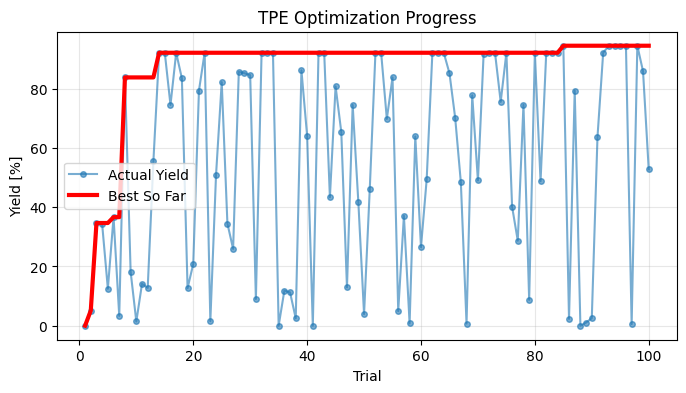

最適化履歴を ../runs/optuna_tpe_100trials_BH/visualization/optimization_progress.png に保存しました


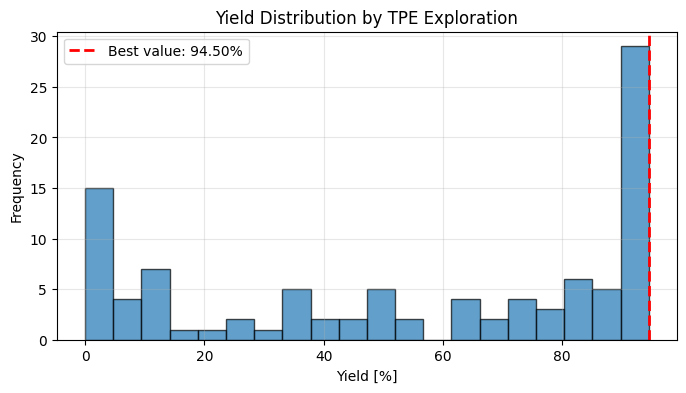

収率分布を ../runs/optuna_tpe_100trials_BH/visualization/yield_distribution.png に保存しました


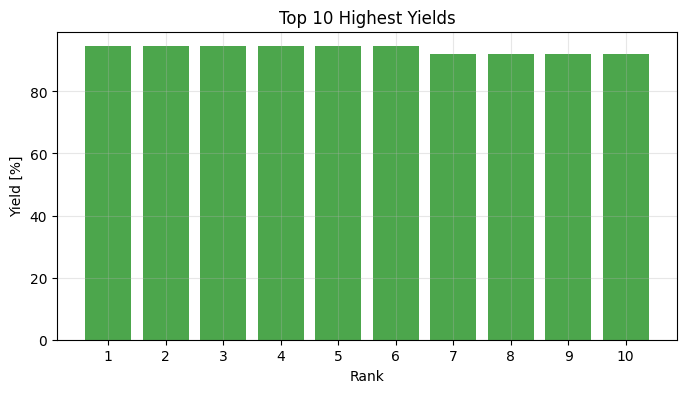

Top 10収率を ../runs/optuna_tpe_100trials_BH/visualization/top10_yields.png に保存しました


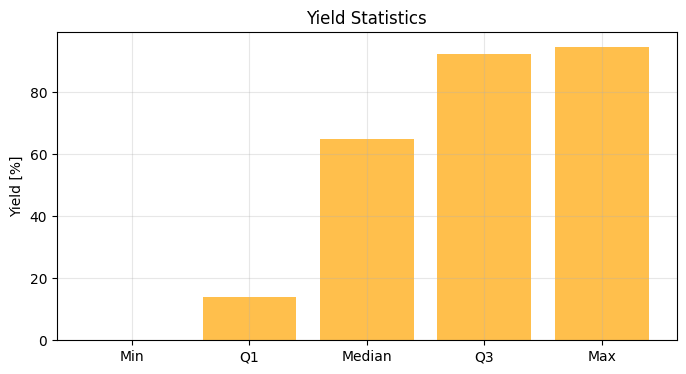

収率統計を ../runs/optuna_tpe_100trials_BH/visualization/yield_statistics.png に保存しました


In [9]:
plt.style.use('default')

# 1. 最適化履歴
fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, len(trial_values)+1), trial_values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
plt.plot(range(1, len(trial_values)+1), best_values, 'r-', linewidth=3, label='Best So Far')
plt.xlabel('Trial')
plt.ylabel('Yield [%]')
plt.title('TPE Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/optimization_progress.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"最適化履歴を {viz_dir}/optimization_progress.png に保存しました")

# 2. 収率分布
fig = plt.figure(figsize=(8, 4))
plt.hist(trial_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best value: {study.best_value:.2f}%')
plt.xlabel('Yield [%]')
plt.ylabel('Frequency')
plt.title('Yield Distribution by TPE Exploration')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率分布を {viz_dir}/yield_distribution.png に保存しました")

# 3. Top 10 収率
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
top_values = [t.value for t in top_trials]
top_indices = list(range(1, 11))

fig = plt.figure(figsize=(8, 4))
plt.bar(top_indices, top_values, alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Yield [%]')
plt.title('Top 10 Highest Yields')
plt.xticks(top_indices)
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/top10_yields.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Top 10収率を {viz_dir}/top10_yields.png に保存しました")

# 4. 収率の統計情報
stats_data = [np.min(trial_values), np.percentile(trial_values, 25), 
              np.median(trial_values), np.percentile(trial_values, 75), np.max(trial_values)]
stats_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']

fig = plt.figure(figsize=(8, 4))
plt.bar(stats_labels, stats_data, alpha=0.7, color='orange')
plt.ylabel('Yield [%]')
plt.title('Yield Statistics')
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_statistics.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率統計を {viz_dir}/yield_statistics.png に保存しました")

## GPSampler

In [10]:
def run_gp_optimization(
    n_trials: int = 100,
    seed: int = 42,
    db_path: str = "../runs/optuna_gp_100trials_BH/optuna_gp_100trials_BH.db",
    *,
    n_startup_trials: int = 10,
    deterministic_objective: bool = False,
):
    """
    反応収率最大化のためのGaussian Process( GP )最適化を実行（Optuna GPSampler）

    Args:
        n_trials (int): 最適化試行回数
        seed (int): 再現性のためのランダムシード
        db_path (str): 結果保存用SQLiteデータベースのパス
        n_startup_trials (int): 初期のランダム探索回数（既知データが少ない序盤を安定化）
        deterministic_objective (bool): 目的関数が決定的なら True（ノイズを想定しない学習）

    Returns:
        optuna.Study: 完了した最適化スタディ
    """

    # 出力ディレクトリの作成
    os.makedirs(os.path.dirname(db_path), exist_ok=True)

    # GPサンプラーを設定
    sampler = GPSampler(
        seed=seed,
        n_startup_trials=n_startup_trials,
        deterministic_objective=deterministic_objective,
    )

    # 新規スタディの作成または既存スタディの読み込み
    study = optuna.create_study(
        direction="maximize",                     # 収率を最大化
        sampler=sampler,                          # GPサンプラーを使用
        study_name="gp_yield_optimization_BH",
        storage=f"sqlite:///{db_path}",           # 永続化ストレージ
        load_if_exists=True,                      # 既存DBがあれば再利用
    )

    # 最適化の実行
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # 最適化結果の表示
    print("最適化完了")
    print(f"最良の収率: {study.best_value:.2f}%")
    print("最適な反応条件:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"最適化結果の保存先: {db_path}")
    return study


In [11]:
 study = run_gp_optimization(n_trials=100, seed=42)

[I 2025-09-25 06:19:45,676] A new study created in RDB with name: gp_yield_optimization_BH
Best trial: 1. Best value: 5.10513:   2%|▏         | 2/100 [00:00<00:16,  5.84it/s]

[I 2025-09-25 06:19:45,853] Trial 0 finished with value: 0.0 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 0 with value: 0.0.
[I 2025-09-25 06:19:46,017] Trial 1 finished with value: 5.105134806 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=CON=C1C=CC=C2', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 1 with value: 5.105134806.


Best trial: 2. Best value: 34.6702:   4%|▍         | 4/100 [00:00<00:16,  5.68it/s]

[I 2025-09-25 06:19:46,184] Trial 2 finished with value: 34.67021781 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'FC(C=CC=C1F)=C1C2=CC=NO2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 2 with value: 34.67021781.
[I 2025-09-25 06:19:46,370] Trial 3 finished with value: 34.22216946 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 2 with value: 34.67021781.


Best trial: 5. Best value: 36.6429:   6%|▌         | 6/100 [00:01<00:17,  5.44it/s]

[I 2025-09-25 06:19:46,580] Trial 4 finished with value: 12.48635948 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'ClC1=CN=CC=C1'}. Best is trial 2 with value: 34.67021781.
[I 2025-09-25 06:19:46,754] Trial 5 finished with value: 36.64285561 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 5 with value: 36.64285561.


Best trial: 7. Best value: 83.8039:   8%|▊         | 8/100 [00:01<00:16,  5.59it/s]

[I 2025-09-25 06:19:46,927] Trial 6 finished with value: 3.339136515 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=C(C(OCC)=O)C=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CC=C(CC)C=C1'}. Best is trial 5 with value: 36.64285561.
[I 2025-09-25 06:19:47,104] Trial 7 finished with value: 83.80386815 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:  10%|█         | 10/100 [00:01<00:16,  5.47it/s]

[I 2025-09-25 06:19:47,314] Trial 8 finished with value: 18.20970217 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'O=C(OC)C1=NOC(C2=CC=CO2)=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 7 with value: 83.80386815.
[I 2025-09-25 06:19:47,483] Trial 9 finished with value: 1.426630798 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=CC(N2C=CC=C2)=NO1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 7. Best value: 83.8039:  11%|█         | 11/100 [00:03<00:56,  1.59it/s]

[I 2025-09-25 06:19:49,123] Trial 10 finished with value: 79.68761126 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 7 with value: 83.80386815.


Best trial: 11. Best value: 86.0898:  12%|█▏        | 12/100 [00:03<00:46,  1.91it/s]

[I 2025-09-25 06:19:49,407] Trial 11 finished with value: 86.08980917 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 11 with value: 86.08980917.


Best trial: 11. Best value: 86.0898:  13%|█▎        | 13/100 [00:04<00:39,  2.19it/s]

[I 2025-09-25 06:19:49,711] Trial 12 finished with value: 27.15696835 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 11 with value: 86.08980917.


Best trial: 11. Best value: 86.0898:  14%|█▍        | 14/100 [00:04<00:35,  2.40it/s]

[I 2025-09-25 06:19:50,036] Trial 13 finished with value: 35.81675951 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 11 with value: 86.08980917.


Best trial: 11. Best value: 86.0898:  15%|█▌        | 15/100 [00:04<00:32,  2.63it/s]

[I 2025-09-25 06:19:50,329] Trial 14 finished with value: 55.56585889 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 11 with value: 86.08980917.


Best trial: 15. Best value: 95.129:  16%|█▌        | 16/100 [00:04<00:29,  2.80it/s] 

[I 2025-09-25 06:19:50,632] Trial 15 finished with value: 95.12897845 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  17%|█▋        | 17/100 [00:05<00:28,  2.91it/s]

[I 2025-09-25 06:19:50,946] Trial 16 finished with value: 43.53836522 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CS2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  18%|█▊        | 18/100 [00:05<00:27,  3.02it/s]

[I 2025-09-25 06:19:51,247] Trial 17 finished with value: 82.63071562 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  19%|█▉        | 19/100 [00:05<00:25,  3.14it/s]

[I 2025-09-25 06:19:51,534] Trial 18 finished with value: 92.39124083 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  20%|██        | 20/100 [00:06<00:25,  3.16it/s]

[I 2025-09-25 06:19:51,846] Trial 19 finished with value: 54.23706273 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(OC)C=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  21%|██        | 21/100 [00:06<00:24,  3.20it/s]

[I 2025-09-25 06:19:52,153] Trial 20 finished with value: 94.14846732 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  22%|██▏       | 22/100 [00:06<00:24,  3.22it/s]

[I 2025-09-25 06:19:52,457] Trial 21 finished with value: 50.10376029 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(OC)C=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  23%|██▎       | 23/100 [00:07<00:23,  3.30it/s]

[I 2025-09-25 06:19:52,745] Trial 22 finished with value: 92.89765441 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 15. Best value: 95.129:  24%|██▍       | 24/100 [00:07<00:23,  3.27it/s]

[I 2025-09-25 06:19:53,056] Trial 23 finished with value: 3.135484875 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(CC)C=C1'}. Best is trial 15 with value: 95.12897845.


Best trial: 24. Best value: 95.7526:  25%|██▌       | 25/100 [00:07<00:23,  3.20it/s]

[I 2025-09-25 06:19:53,382] Trial 24 finished with value: 95.75260589 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  26%|██▌       | 26/100 [00:08<00:23,  3.16it/s]

[I 2025-09-25 06:19:53,705] Trial 25 finished with value: 90.31730943 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  27%|██▋       | 27/100 [00:08<00:24,  3.01it/s]

[I 2025-09-25 06:19:54,078] Trial 26 finished with value: 86.76065944 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  28%|██▊       | 28/100 [00:08<00:22,  3.16it/s]

[I 2025-09-25 06:19:54,355] Trial 27 finished with value: 89.47412112 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  29%|██▉       | 29/100 [00:09<00:22,  3.17it/s]

[I 2025-09-25 06:19:54,667] Trial 28 finished with value: 94.54981251 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  30%|███       | 30/100 [00:09<00:21,  3.26it/s]

[I 2025-09-25 06:19:54,959] Trial 29 finished with value: 91.69839995 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  31%|███       | 31/100 [00:09<00:20,  3.29it/s]

[I 2025-09-25 06:19:55,255] Trial 30 finished with value: 92.12702212 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  32%|███▏      | 32/100 [00:10<00:24,  2.81it/s]

[I 2025-09-25 06:19:55,734] Trial 31 finished with value: 82.57086092 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  33%|███▎      | 33/100 [00:10<00:22,  2.94it/s]

[I 2025-09-25 06:19:56,037] Trial 32 finished with value: 63.99072189 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 24. Best value: 95.7526:  34%|███▍      | 34/100 [00:10<00:21,  3.03it/s]

[I 2025-09-25 06:19:56,343] Trial 33 finished with value: 95.07020116 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 24 with value: 95.75260589.


Best trial: 34. Best value: 99.0345:  35%|███▌      | 35/100 [00:11<00:21,  3.01it/s]

[I 2025-09-25 06:19:56,678] Trial 34 finished with value: 99.03446213 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  36%|███▌      | 36/100 [00:11<00:21,  3.04it/s]

[I 2025-09-25 06:19:57,002] Trial 35 finished with value: 94.50096737 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  37%|███▋      | 37/100 [00:11<00:22,  2.81it/s]

[I 2025-09-25 06:19:57,420] Trial 36 finished with value: 92.13068227 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  38%|███▊      | 38/100 [00:12<00:31,  2.00it/s]

[I 2025-09-25 06:19:58,257] Trial 37 finished with value: 35.68280094 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=CON=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  39%|███▉      | 39/100 [00:12<00:27,  2.20it/s]

[I 2025-09-25 06:19:58,605] Trial 38 finished with value: 95.55515456 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  40%|████      | 40/100 [00:14<00:42,  1.41it/s]

[I 2025-09-25 06:19:59,909] Trial 39 finished with value: 84.91024962 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  41%|████      | 41/100 [00:14<00:35,  1.66it/s]

[I 2025-09-25 06:20:00,262] Trial 40 finished with value: 82.20776042 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C2=CC=CC=C2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  42%|████▏     | 42/100 [00:14<00:29,  1.95it/s]

[I 2025-09-25 06:20:00,562] Trial 41 finished with value: 84.40270662 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  43%|████▎     | 43/100 [00:15<00:25,  2.19it/s]

[I 2025-09-25 06:20:00,888] Trial 42 finished with value: 86.19820374 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  44%|████▍     | 44/100 [00:15<00:23,  2.35it/s]

[I 2025-09-25 06:20:01,239] Trial 43 finished with value: 74.51133845 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=C(C=CC=C2)ON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  45%|████▌     | 45/100 [00:15<00:21,  2.57it/s]

[I 2025-09-25 06:20:01,546] Trial 44 finished with value: 86.79260178 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  46%|████▌     | 46/100 [00:16<00:20,  2.64it/s]

[I 2025-09-25 06:20:01,900] Trial 45 finished with value: 85.22067267 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'COC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  47%|████▋     | 47/100 [00:16<00:19,  2.77it/s]

[I 2025-09-25 06:20:02,222] Trial 46 finished with value: 74.59231799 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(N2C=CC=C2)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  48%|████▊     | 48/100 [00:16<00:18,  2.85it/s]

[I 2025-09-25 06:20:02,547] Trial 47 finished with value: 83.95560608 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CO2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  49%|████▉     | 49/100 [00:17<00:17,  2.87it/s]

[I 2025-09-25 06:20:02,890] Trial 48 finished with value: 2.510510682 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  50%|█████     | 50/100 [00:17<00:19,  2.50it/s]

[I 2025-09-25 06:20:03,410] Trial 49 finished with value: 69.94718927 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  51%|█████     | 51/100 [00:17<00:16,  2.92it/s]

[I 2025-09-25 06:20:03,618] Trial 50 finished with value: 47.34357171 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=C(C(OCC)=O)C=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  52%|█████▏    | 52/100 [00:18<00:15,  3.07it/s]

[I 2025-09-25 06:20:03,903] Trial 51 finished with value: 70.62989218 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  53%|█████▎    | 53/100 [00:18<00:14,  3.35it/s]

[I 2025-09-25 06:20:04,141] Trial 52 finished with value: 96.13228316 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  54%|█████▍    | 54/100 [00:18<00:12,  3.55it/s]

[I 2025-09-25 06:20:04,382] Trial 53 finished with value: 93.56409267 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:04,581] Trial 54 finished with value: 94.15173815 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  56%|█████▌    | 56/100 [00:19<00:10,  4.17it/s]

[I 2025-09-25 06:20:04,782] Trial 55 finished with value: 92.11972779 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'COC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  58%|█████▊    | 58/100 [00:19<00:09,  4.27it/s]

[I 2025-09-25 06:20:05,070] Trial 56 finished with value: 81.51017538 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:05,257] Trial 57 finished with value: 85.65923047 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  59%|█████▉    | 59/100 [00:19<00:10,  3.83it/s]

[I 2025-09-25 06:20:05,581] Trial 58 finished with value: 87.94083651 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'O=C(OC)C1=NOC(C2=CC=CO2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  60%|██████    | 60/100 [00:20<00:10,  3.86it/s]

[I 2025-09-25 06:20:05,834] Trial 59 finished with value: 89.88953077 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  61%|██████    | 61/100 [00:20<00:09,  4.05it/s]

[I 2025-09-25 06:20:06,055] Trial 60 finished with value: 67.67136056 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  63%|██████▎   | 63/100 [00:21<00:12,  3.07it/s]

[I 2025-09-25 06:20:06,760] Trial 61 finished with value: 87.36384149 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:06,949] Trial 62 finished with value: 95.67591323 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  64%|██████▍   | 64/100 [00:21<00:10,  3.46it/s]

[I 2025-09-25 06:20:07,151] Trial 63 finished with value: 92.65898323 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:07,342] Trial 64 finished with value: 84.17796028 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C(OCC)=O)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  66%|██████▌   | 66/100 [00:22<00:09,  3.41it/s]

[I 2025-09-25 06:20:07,704] Trial 65 finished with value: 79.01720716 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=CON=C1C=CC=C2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:07,902] Trial 66 finished with value: 90.64441503 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C2=CC=CC=C2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  68%|██████▊   | 68/100 [00:22<00:07,  4.11it/s]

[I 2025-09-25 06:20:08,101] Trial 67 finished with value: 53.36463944 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  69%|██████▉   | 69/100 [00:22<00:07,  4.24it/s]

[I 2025-09-25 06:20:08,321] Trial 68 finished with value: 99.03446213 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  70%|███████   | 70/100 [00:23<00:14,  2.07it/s]

[I 2025-09-25 06:20:09,380] Trial 69 finished with value: 86.42573792 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'FC(C=CC=C1F)=C1C2=CC=NO2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:09,572] Trial 70 finished with value: 90.73131654 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  72%|███████▏  | 72/100 [00:24<00:09,  2.93it/s]

[I 2025-09-25 06:20:09,787] Trial 71 finished with value: 84.5566149 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  73%|███████▎  | 73/100 [00:25<00:12,  2.20it/s]

[I 2025-09-25 06:20:10,507] Trial 72 finished with value: 46.59177534 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:10,704] Trial 73 finished with value: 79.37053051 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  75%|███████▌  | 75/100 [00:25<00:08,  3.07it/s]

[I 2025-09-25 06:20:10,909] Trial 74 finished with value: 74.31911492 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'COC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  76%|███████▌  | 76/100 [00:26<00:12,  1.87it/s]

[I 2025-09-25 06:20:11,928] Trial 75 finished with value: 0.747631534 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  77%|███████▋  | 77/100 [00:26<00:11,  1.95it/s]

[I 2025-09-25 06:20:12,393] Trial 76 finished with value: 83.93526521 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  78%|███████▊  | 78/100 [00:26<00:09,  2.29it/s]

[I 2025-09-25 06:20:12,652] Trial 77 finished with value: 83.93941968 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  79%|███████▉  | 79/100 [00:28<00:13,  1.56it/s]

[I 2025-09-25 06:20:13,763] Trial 78 finished with value: 38.32865111 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'ClC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  80%|████████  | 80/100 [00:28<00:10,  1.95it/s]

[I 2025-09-25 06:20:13,981] Trial 79 finished with value: 72.94185386 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=CC=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  81%|████████  | 81/100 [00:28<00:07,  2.38it/s]

[I 2025-09-25 06:20:14,186] Trial 80 finished with value: 53.85457225 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  82%|████████▏ | 82/100 [00:29<00:08,  2.14it/s]

[I 2025-09-25 06:20:14,761] Trial 81 finished with value: 81.6084941 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  83%|████████▎ | 83/100 [00:29<00:06,  2.50it/s]

[I 2025-09-25 06:20:15,002] Trial 82 finished with value: 51.1783537 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  84%|████████▍ | 84/100 [00:29<00:05,  2.92it/s]

[I 2025-09-25 06:20:15,215] Trial 83 finished with value: 57.26273694 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(C)=NO1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  85%|████████▌ | 85/100 [00:31<00:10,  1.41it/s]

[I 2025-09-25 06:20:16,780] Trial 84 finished with value: 52.24472601 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  86%|████████▌ | 86/100 [00:31<00:07,  1.78it/s]

[I 2025-09-25 06:20:16,999] Trial 85 finished with value: 1.068125406 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'ClC1=CC=C(OC)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  87%|████████▋ | 87/100 [00:31<00:06,  2.11it/s]

[I 2025-09-25 06:20:17,265] Trial 86 finished with value: 78.46972259 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(C2=CC=CC=C2)=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  88%|████████▊ | 88/100 [00:32<00:06,  1.86it/s]

[I 2025-09-25 06:20:17,951] Trial 87 finished with value: 83.05466982 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CC=C(CC)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  89%|████████▉ | 89/100 [00:32<00:04,  2.22it/s]

[I 2025-09-25 06:20:18,202] Trial 88 finished with value: 43.34412585 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CC=C(OC)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  90%|█████████ | 90/100 [00:32<00:03,  2.62it/s]

[I 2025-09-25 06:20:18,420] Trial 89 finished with value: 76.73986616 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'FC(C=CC=C1F)=C1C2=CC=NO2', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  92%|█████████▏| 92/100 [00:33<00:03,  2.19it/s]

[I 2025-09-25 06:20:19,441] Trial 90 finished with value: 63.88080478 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.
[I 2025-09-25 06:20:19,626] Trial 91 finished with value: 84.70172213 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=CC(N2C=CC=C2)=NO1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  93%|█████████▎| 93/100 [00:34<00:02,  2.58it/s]

[I 2025-09-25 06:20:19,842] Trial 92 finished with value: 77.75555198 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  94%|█████████▍| 94/100 [00:34<00:02,  2.06it/s]

[I 2025-09-25 06:20:20,568] Trial 93 finished with value: 80.80959568 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'C12=C(C=CC=C2)ON=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'IC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  95%|█████████▌| 95/100 [00:35<00:02,  2.38it/s]

[I 2025-09-25 06:20:20,830] Trial 94 finished with value: 63.0697188 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  96%|█████████▌| 96/100 [00:35<00:01,  2.51it/s]

[I 2025-09-25 06:20:21,182] Trial 95 finished with value: 82.64502167 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C2=CC=CC=C2)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=NC=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  97%|█████████▋| 97/100 [00:36<00:01,  1.76it/s]

[I 2025-09-25 06:20:22,145] Trial 96 finished with value: 53.38444046 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'IC1=CC=C(OC)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  98%|█████████▊| 98/100 [00:36<00:00,  2.07it/s]

[I 2025-09-25 06:20:22,428] Trial 97 finished with value: 45.92980056 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC=C1', 'base': 'CC(C)(C)/N=C(N(C)C)/N(C)C', 'aryl_halide': 'BrC1=CC=C(C(F)(F)F)C=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345:  99%|█████████▉| 99/100 [00:36<00:00,  2.46it/s]

[I 2025-09-25 06:20:22,660] Trial 98 finished with value: 89.97416157 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CCOC(C1=NOC=C1)=O', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.


Best trial: 34. Best value: 99.0345: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]

[I 2025-09-25 06:20:24,590] Trial 99 finished with value: 86.53541708 and parameters: {'ligand': 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC', 'additive': 'CC1=NOC(C(OCC)=O)=C1', 'base': 'CN1CCCN2C1=NCCC2', 'aryl_halide': 'BrC1=CN=CC=C1'}. Best is trial 34 with value: 99.03446213.
最適化完了
最良の収率: 99.03%
最適な反応条件:
  ligand: CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC
  additive: CC1=NOC(C(OCC)=O)=C1
  base: CN1CCCN2C1=NCCC2
  aryl_halide: IC1=NC=CC=C1
最適化結果の保存先: ../runs/optuna_gp_100trials_BH/optuna_gp_100trials_BH.db


### 可視化

In [12]:
# 結果読み込みと可視化の設定
db_path = "../runs/optuna_gp_100trials_NiB/optuna_gp_100trials_BH.db"
viz_dir = "../runs/optuna_gp_100trials_BH/visualization"

# 可視化ディレクトリの作成
os.makedirs(viz_dir, exist_ok=True)

# データベースからスタディを読み込み
try:
    study = optuna.load_study(
        study_name="gp_yield_optimization_BH",
        storage=f"sqlite:///{db_path}"
    )
    print(f"✓ データベースからスタディを正常に読み込みました")
    print(f"  総試行数: {len(study.trials)}")
    print(f"  達成された最高収率: {study.best_value:.2f}%")
    print(f"  可視化ディレクトリ: {viz_dir}")

except Exception as e:
    print(f"❌ スタディの読み込み中にエラーが発生しました: {e}")
    print("最適化セクションを先に実行してください！")

❌ スタディの読み込み中にエラーが発生しました: 'Record does not exist.'
最適化セクションを先に実行してください！


In [13]:
trial_values = [t.value for t in study.trials if t.value is not None]
best_values = np.maximum.accumulate(trial_values)

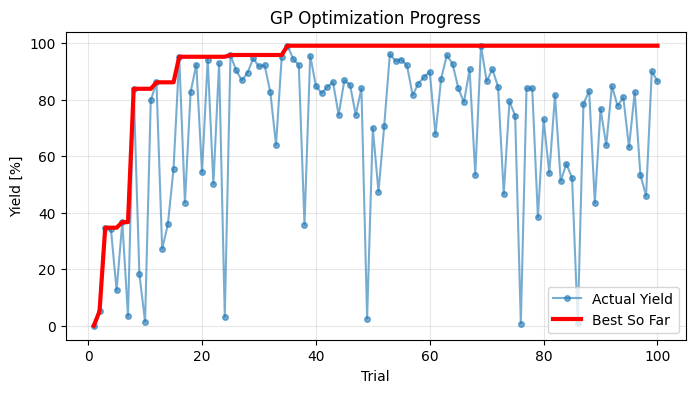

最適化履歴を ../runs/optuna_gp_100trials_BH/visualization/optimization_progress.png に保存しました


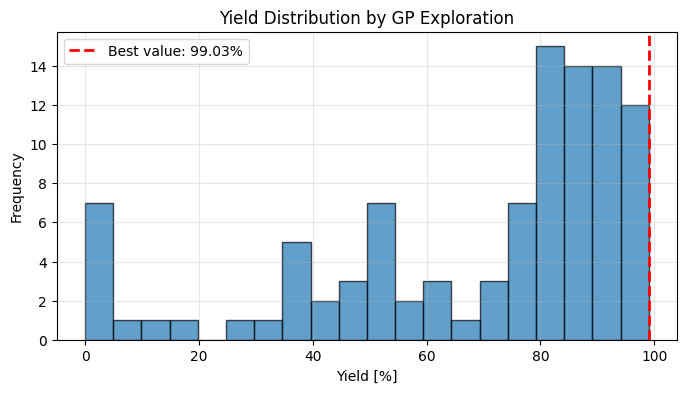

収率分布を ../runs/optuna_gp_100trials_BH/visualization/yield_distribution.png に保存しました


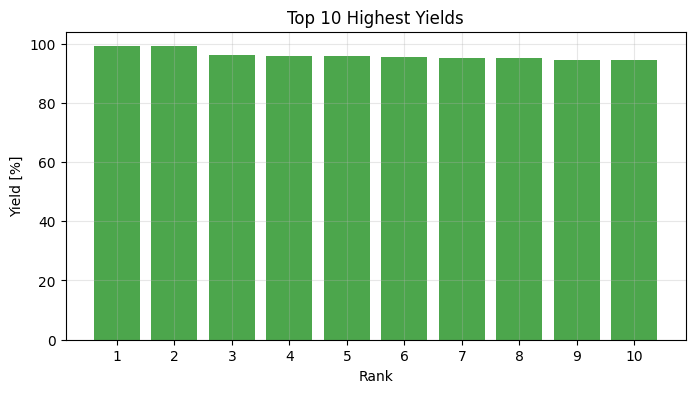

Top 10収率を ../runs/optuna_gp_100trials_BH/visualization/top10_yields.png に保存しました


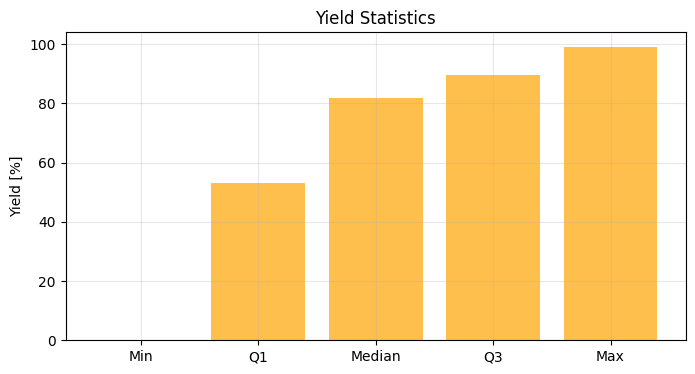

収率統計を ../runs/optuna_gp_100trials_BH/visualization/yield_statistics.png に保存しました


In [14]:
plt.style.use('default')

# 1. 最適化履歴
fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, len(trial_values)+1), trial_values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
plt.plot(range(1, len(trial_values)+1), best_values, 'r-', linewidth=3, label='Best So Far')
plt.xlabel('Trial')
plt.ylabel('Yield [%]')
plt.title('GP Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/optimization_progress.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"最適化履歴を {viz_dir}/optimization_progress.png に保存しました")

# 2. 収率分布
fig = plt.figure(figsize=(8, 4))
plt.hist(trial_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', linewidth=2, label=f'Best value: {study.best_value:.2f}%')
plt.xlabel('Yield [%]')
plt.ylabel('Frequency')
plt.title('Yield Distribution by GP Exploration')
plt.legend()
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率分布を {viz_dir}/yield_distribution.png に保存しました")

# 3. Top 10 収率
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:10]
top_values = [t.value for t in top_trials]
top_indices = list(range(1, 11))

fig = plt.figure(figsize=(8, 4))
plt.bar(top_indices, top_values, alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Yield [%]')
plt.title('Top 10 Highest Yields')
plt.xticks(top_indices)
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/top10_yields.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"Top 10収率を {viz_dir}/top10_yields.png に保存しました")

# 4. 収率の統計情報
stats_data = [np.min(trial_values), np.percentile(trial_values, 25), 
              np.median(trial_values), np.percentile(trial_values, 75), np.max(trial_values)]
stats_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']

fig = plt.figure(figsize=(8, 4))
plt.bar(stats_labels, stats_data, alpha=0.7, color='orange')
plt.ylabel('Yield [%]')
plt.title('Yield Statistics')
plt.grid(True, alpha=0.3)
fig.savefig(f"{viz_dir}/yield_statistics.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"収率統計を {viz_dir}/yield_statistics.png に保存しました")